# Spend engine
## Objective
Develop code for generating spending projections based on:
- underlying lifecycle profile (launch to patent expiry etc)
- successive cohorts of launches
 
Allow for:
- growth between cohorts
- continuing spend at end of lifecycle
- discontinuous changes - eg one-off multiplication of profile
 
Plot locally for now, but will want to integrate with web app / UI.
 
## Status
Based on the `SpendObject` class.  Instances takes a *discontinous* profile (as a `np.array`), timings, growth rates etc.  Can then return spend projections (as pandas `pd.Series`) for a given time period with the `[instance].get_pd(periods)` method.  
Basic engine seems to work.  
Can use any time periods / intervals, but currently won't deal with dates as such (only years *or* months - ie a single time unit)

## Notes
Leaves profile generation to some other functionality.  Could use three approaches to generate the input:
- directly generate the monthly profile
- generate from a continuous function
- generate from a set of user-defined points

## Next up
- Allow a time range input to `.get_pd()` - so successive sets of spend are consistent (currently needs manually setting the lengths so the total period is the same. Might be best to do this at creation still, calculating appropriate lengths based on the period of interest - especially if doing that automatically.    
- Sort so it can deal with months *and* years  (use pandas date format).  [Remember to divide annual growth rates etc by 12]  
- Enable object parameters to be changed (?) eg growth rate.  Tho need to repeat the `get_np` which takes the time.
- Options for dumping eg to excel?  Debug output?  
- Actually check the results are right! Excel probably. 
- Write some unit tests  
- Think about any errors might need catching

## Main code

In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [128]:
class SpendObject:
    '''Defines a body of spending based on a period of launches (cohorts), each of which follows
    a fundamental profile.
    Also reflects cohort growth (i.e. change in magnitude of profile over successive cohorts).
    The period for calculating spend is open:  the last period in the profile is taken to be the
    "terminal" spend, which continues indefinitely, changing according to the terminal growth rate 
    (this would normally be negative).
    '''
    
    def __init__(self, profile, launch_start, launch_stop, 
                 coh_growth=0, term_growth=0, scale=1, name='spend_obj'):
        
        self.raw_profile = profile
        self.profile = profile * scale
        self.prof_scale = scale
        self.l_start = launch_start
        self.l_stop = launch_stop
        self.launch_pers = self.l_stop -1 - self.l_start # need the minus 1 as input is one past end
        self.prof_len = len(profile)
        self.coh_growth = coh_growth
        self.term_growth = term_growth
        self.term_value = profile[-1]
        self.name = name       

        self._info = {"name": self.name,
                     "first launch period": self.l_start,
                     "last launch period": self.l_stop,
                     "profile length": self.prof_len,
                     "profile scaling": self.prof_scale,
                     "profile max value (scaled)": max(self.profile),
                     "profile max period": self.profile.argmax(axis=0),
                     "terminal value": self.term_value,
                     "cohort growth rate": self.coh_growth,
                     "terminal growth rate": self.term_growth}


####################################### MAIN METHOD #############################################
    
            
    def _spender(self, spend_per, debug=False):
        '''Generator function which iterates through all cohorts extant at spend_per,
        yielding spend adjusted for cohort growth and terminal change.  
        Designed to be consumed with sum(self._spender(spend_per)).
        '''
        
        # NB - USES ZERO-BASED INDEXING FOR EVERYTHING
        
        # First, define the frame by going back from the spend period by the number of launch periods
        # This frame must give the actual indexes of relevant elements of the profile for iterating
        # Zero based, and wants to go one past the end (because that's how iteration works)
        
        frame = (max(0, spend_per - self.launch_pers), spend_per+1)   
        
            # eg if spend_per is 5 (6 periods) and there are 2 cohorts, then want indices 4-5
            # so frame is (3,6)
        
        f_start, f_end = frame
        last_coh = min(self.launch_pers, spend_per) # minus 1 to make zero based
        
        if debug:
            print("frame ", frame, "cohorts ", last_coh+1)
            titles = "prof point, coh id, raw val, coh adj, term adj, total adj,   val".split(",")
            pads = [len(t)-1 for t in titles]
            print(" |".join(titles))

        # Iterate through the frame (i.e. through the cohorts), yielding the spend at the
        # corresponding profile point, adjusted as necessary. 
        # If the profile point is beyond the terminal, then calculate appropriately
       
        for i, prof_point in enumerate(range(f_start, f_end)):
            
            # Helps to know which cohort we're on. Last period in  frame corresponds to the 0th cohort.
            # So the first will correspond to the last launch period (minus 1 to make start at zero).  
            # Then iterate through with the index
            coh_id = last_coh - i
            coh_adj = (1+self.coh_growth)**coh_id # used to adjust for growth between cohorts
            term_adj = 1 # will be used to adjust for change after period - set to 1 initially
            
            if debug: print(str(prof_point).rjust(pads[0]+1), "|", 
                            str(coh_id).rjust(pads[1]), "|", end="") 
                            
           
            # As long as the period is within the profile, yield the corresponding profile point
            if prof_point < self.prof_len: # length is one past the last index
                val = self.profile[prof_point] * coh_adj # adjust for cohort growth              

                
            # If the period is beyond the profile, use the terminal value
            else:
                # adjust the terminal value by the cohort growth, then for change after terminal period
                term_adj = (1+self.term_growth)**(prof_point - self.prof_len+1)
                val = self.term_value * coh_adj * term_adj

            if debug: 
                if prof_point < self.prof_len:
                    raw_val = self.profile[prof_point]
                    term_adj_str = "-"
                else:
                    raw_val = self.term_value
                    term_adj_str = "{0:.3f}".format(term_adj)
                    
                print(str(raw_val).rjust(pads[2]), " |", 
                          "{0:.3f}".format(coh_adj).rjust(pads[3]),  "|",
                          term_adj_str.rjust(pads[4]), "|", 
                          "{0:.3f}".format(term_adj*coh_adj).rjust(pads[5]), "|", 
                          "{0:.2f}".format(val).rjust(pads[6])) 
            yield val

############################################ --- ENDS --- ##############################################


    # This allows instances to be indexed to give spend at any time point or slice.  Not sure if useful.
    def __getitem__(self, sl):
        # test if it's a single index, rather than a slice
        if isinstance(sl,int):
            return sum(self._spender(sl))
        else:
            slice_out = []
            for i in range(sl.start, sl.stop):
                slice_out.append(sum(self._spender(i)))
            return slice_out
    
    # Returns a string with info when the instance is called by name
    def __repr__(self):
        outlist = []
        for key in self._info:
            temp_string = key.ljust(27) + str(self._info[key]).rjust(10)
            outlist.append(temp_string)
        return "\n".join(outlist)
    
    # This does the work for generating the projection, calling the _spender function for each period.
    def get_np(self, max_per, debug=False):
        np_out = np.zeros(max_per)
        if debug: print(self.__repr__())
        for i, per in enumerate(range(max_per)):
            if debug: print("\nGetting period ", per)
            np_out[i] = sum(self._spender(per, debug))
            if debug: print("Period ", per, "result ", np_out[i])
        return np_out
    
    # A pandas series wrapper around the np array, with index shifted appropriately 
    def get_pd(self, max_per, debug=False):
        return pd.Series(self.get_np(max_per, debug=debug), 
                         index=range(self.l_start, self.l_start+max_per), 
                         name=self.name)
        

#________________________________________________________________________________________#
    

## Usage
First create some profiles

In [99]:
test_profile = np.array([1,2,5,10,11,12,1])
test_profile_no_term = np.array([1,2,5,10,11,12,0])
test_profile_1 = np.array([1]*5)

### Demos
- create a spend object
- return object (repr) 
- create pd (with debug)
- plot
- concat and plot

#### Basic usage, creating a spend object

In [100]:
demo_0 = SpendObject(test_profile, 2001, 2010, 0.1, -0.1, 1, "demo 0")
demo_0

name                           demo 0
first launch period              2001
last launch period               2010
profile length                      7
profile scaling                     1
profile max value (scaled)         12
profile max period                  5
terminal value                      1
cohort growth rate                0.1
terminal growth rate             -0.1

#### Now get the spend projection for a given number of periods
- Eg 20 periods
- Check what's going on with debug flag - shows the full calculation for each period

In [129]:
pd_0 = demo_0.get_pd(20, debug=True)

name                           demo 0
first launch period              2001
last launch period               2010
profile length                      7
profile scaling                     1
profile max value (scaled)         12
profile max period                  5
terminal value                      1
cohort growth rate                0.1
terminal growth rate             -0.1

Getting period  0
frame  (0, 1) cohorts  1
prof point | coh id | raw val | coh adj | term adj | total adj |   val
         0 |      0 |      1  |   1.000 |        - |     1.000 |  1.00
Period  0 result  1.0

Getting period  1
frame  (0, 2) cohorts  2
prof point | coh id | raw val | coh adj | term adj | total adj |   val
         0 |      1 |      1  |   1.100 |        - |     1.100 |  1.10
         1 |      0 |      2  |   1.000 |        - |     1.000 |  2.00
Period  1 result  3.1

Getting period  2
frame  (0, 3) cohorts  3
prof point | coh id | raw val | coh adj | term adj | total adj |   val
         0 |      

- Output is a pandas Series
- Can apply all pd.Series methods

In [115]:
pd_0

2001     1.000000
2002     3.100000
2003     8.410000
2004    19.251000
2005    32.176100
2006    47.393710
2007    53.133081
2008    59.346389
2009    66.091028
2010    71.071183
2011    74.118506
2012    70.331108
2013    54.316183
2014    34.288674
2015     9.852636
2016     8.867372
2017     7.980635
2018     7.182572
2019     6.464314
2020     5.817883
Name: demo 0, dtype: float64

## Plotting spend objects
### Simple pair to check functionality
- create two objects and series, for successive decades of launches
- plot separately and stacked, to check everything lines up
- remember the last year passed to the object is treated as "one past" the actual last year - so need to overlap this when plotting successive periods of launches, or will miss a year.  Might change this so the actual last year is passed.

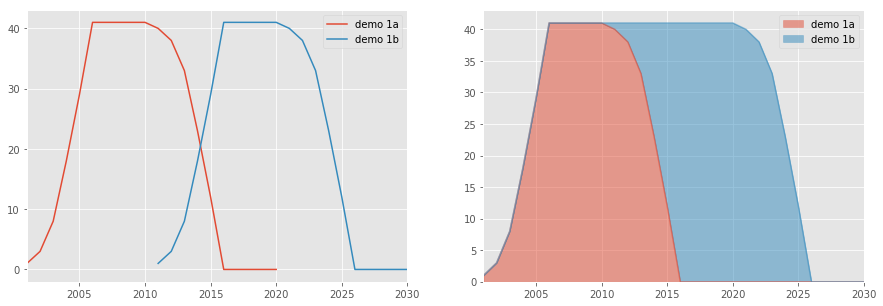

In [112]:
demo_1a = SpendObject(test_profile_no_term, 2001, 2011, 0, 0, 1, "demo 1a")
pd_1a = demo_1a.get_pd(20, debug=False)

demo_1b = SpendObject(test_profile_no_term, 2011, 2021, 0, 0, 1, "demo 1b")
pd_1b = demo_1b.get_pd(20, debug=False)

fig, axs = plt.subplots(1,2)
pd.concat([pd_1a, pd_1b], axis=1).plot(ax=axs[0], figsize=(15,5))
pd.concat([pd_1a, pd_1b], axis=1).plot(ax=axs[1], kind="area", stacked=True, alpha=0.5)

It looks like it's right - identical successive cohorts are the same as a single cohort would be.

### Another pair, this time with more going on
- cohort and terminal growth (note profile has terminal spend, unlike above)
- second period scaled to reflect cohort growth in first period

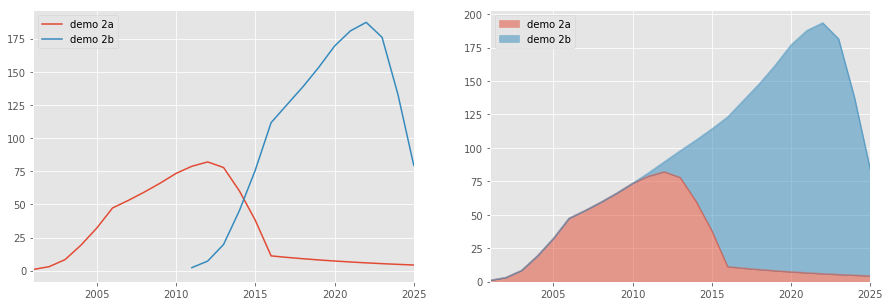

In [119]:
demo_2a = SpendObject(test_profile, 2001, 2011, 0.1, -0.1, 1, "demo 2a")
pd_2a = demo_2a.get_pd(25, debug=False)

demo_2b = SpendObject(test_profile, 2011, 2021, 0.1, -0.1, 1.1**9, "demo 2b")
pd_2b = demo_2b.get_pd(15, debug=False)

fig, axs = plt.subplots(1,2)
pd.concat([pd_2a, pd_2b], axis=1).plot(ax=axs[0], figsize=(15,5))
pd.concat([pd_2a, pd_2b], axis=1).plot(ax=axs[1], kind="area", stacked=True, alpha=0.5)

## Creating multiple objects - representing annual cohorts

Can automate / parameterise generation of objects and projections.  Eg
- Main use of `SpendObject` is to represent an ongoing or long-running set of spend.  
- But can also use it to model individual annual cohorts.  
- Create a series of annual cohorts in a loop
- NB 20% pa cohort growth applied separately, in the scaling argument  (huge effect)

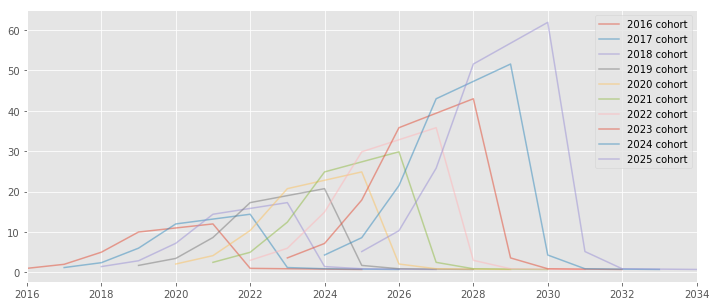

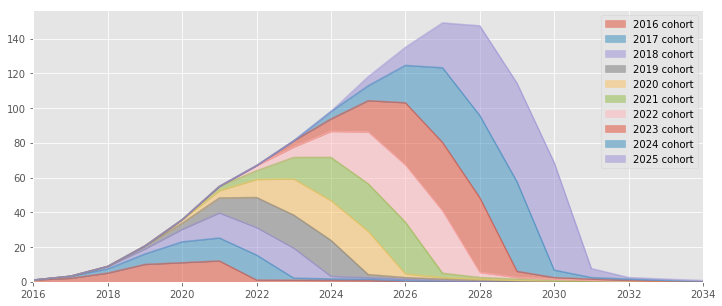

In [126]:
series = []
for i, year in enumerate(range(2016, 2026)):
    obj = SpendObject(test_profile, year, year+1, 0, -0.1, 1.2**i, str(year)+" cohort")
    series.append(obj.get_pd(10))

pd.concat(series, axis=1).plot(alpha=0.5, figsize=(12,5))
pd.concat(series, axis=1).plot(kind="area", stacked=True, alpha=0.5, figsize=(12,5))





# [Scratch]

#### NB need to upgrade successive objects if the first has had growth

These look odd, with a large gap / notch between the two periods.  But it's just because the second period is starting from the same basic profile - and the growth that's built up by the end of the first period is rubbed off.  
(Watch out also for leaving a year gap - see above).


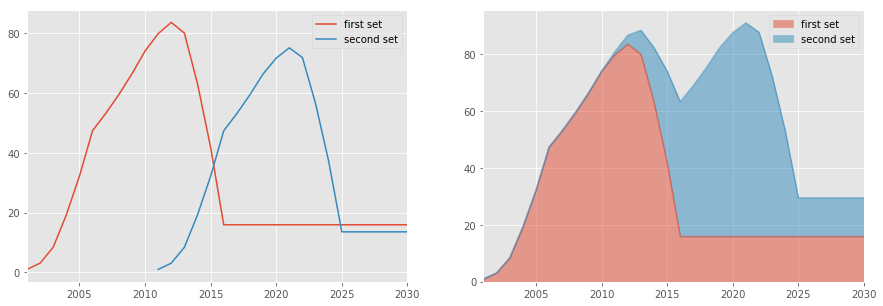

In [106]:
coh0 = SpendObject(test_profile, 2001, 2011, 0.1, 0, 1, "first set")
pd0 = coh0.get_pd(30, debug=False)

coh1 = SpendObject(test_profile, 2011, 2020, 0.1, 0, 1, "second set")
pd1 = coh1.get_pd(20)

fig, axs = plt.subplots(1,2)
pd.concat([pd0, pd1], axis=1).plot(ax=axs[0], figsize=(15,5))
pd.concat([pd0, pd1], axis=1).plot(ax=axs[1], kind="area", stacked=True, alpha=0.5)

#### Using pandas date format

In [107]:
pd.date_range('2013', periods=6, freq='M')

DatetimeIndex(['2013-01-31', '2013-02-28', '2013-03-31', '2013-04-30',
               '2013-05-31', '2013-06-30'],
              dtype='datetime64[ns]', freq='M')